# Must ensure that tf and keras version is 2.15.0

In [ ]:
!pip show tensorflow
!pip show keras

In [ ]:
# GPU availability check
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

In [ ]:
!pip uninstall -y tensorflow
!pip uninstall -y keras

In [ ]:
!pip install tensorflow==2.15.0
!pip install -q keras==2.15.0

In [ ]:
!pip show tensorflow
!pip show keras

In [ ]:
!pip install -q tensorflow-addons

In [1]:
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow_addons as tfa
from keras import backend as K
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2024-08-16 16:28:00.895780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 16:28:00.895829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 16:28:00.897324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
!kaggle datasets download -d shadmansobhan/ham10k-base

Dataset URL: https://www.kaggle.com/datasets/shadmansobhan/ham10k-base
License(s): unknown
100%|███████████████████████████████████████▊| 208M/209M [00:10<00:00, 18.3MB/s]
100%|████████████████████████████████████████| 209M/209M [00:10<00:00, 21.7MB/s]


In [3]:
import zipfile
import os

# Path to the ZIP file
zip_file_path = '/kaggle/working/ham10k-base.zip'

# Directory where you want to extract the contents
extract_dir = '/kaggle/working/ham10k/'

# Create the directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extraction completed. Files are extracted to {extract_dir}")


Extraction completed. Files are extracted to /kaggle/working/ham10k/


In [4]:
#Generating Labels
data_dir = "/kaggle/working/ham10k"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
#Showing dataframe
print(df)
print("Unique labels in the DataFrame:")
print(df['labels'].unique())

                                         filepaths labels
0      /kaggle/working/ham10k/MEL/ISIC_0030507.jpg    MEL
1      /kaggle/working/ham10k/MEL/ISIC_0033362.jpg    MEL
2      /kaggle/working/ham10k/MEL/ISIC_0031844.jpg    MEL
3      /kaggle/working/ham10k/MEL/ISIC_0024962.jpg    MEL
4      /kaggle/working/ham10k/MEL/ISIC_0032447.jpg    MEL
...                                            ...    ...
10010  /kaggle/working/ham10k/BKL/ISIC_0029596.jpg    BKL
10011  /kaggle/working/ham10k/BKL/ISIC_0032773.jpg    BKL
10012  /kaggle/working/ham10k/BKL/ISIC_0030372.jpg    BKL
10013  /kaggle/working/ham10k/BKL/ISIC_0029588.jpg    BKL
10014  /kaggle/working/ham10k/BKL/ISIC_0028623.jpg    BKL

[10015 rows x 2 columns]
Unique labels in the DataFrame:
['MEL' 'BCC' 'DF' 'NV' 'AKIEC' 'VASC' 'BKL']


In [6]:
print("Unique labels in the DataFrame:")
print(df['labels'].unique())

Unique labels in the DataFrame:
['MEL' 'BCC' 'DF' 'NV' 'AKIEC' 'VASC' 'BKL']


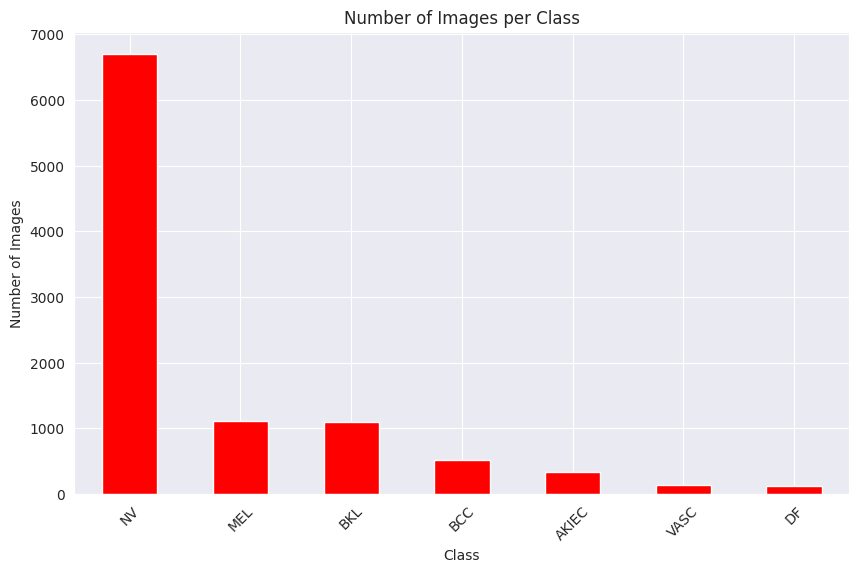

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df has a column 'class' that contains the class labels
# You can replace 'class' with the actual name of the column in your dataframe

# Count the number of images in each class
class_counts = df['labels'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='red')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


In [8]:
balanced_df=df

In [9]:
#Train Test Split

from sklearn.model_selection import train_test_split

# Split data into training and test sets (you can also create a validation set if needed)
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['labels'], random_state=42)

# Further split the training data into training and validation sets (if needed)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

class_counts_train = train_df['labels'].value_counts()

# Print the counts for each class in the training set
print("Class counts in training set:")
print(class_counts_train)


Class counts in training set:
labels
NV       4291
MEL       712
BKL       703
BCC       329
AKIEC     209
VASC       91
DF         74
Name: count, dtype: int64


In [10]:
import os
import cv2
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
#Data Generator for training
#very important for batch_size, test_batch_size

import cv2

def tf_equalize_histogram(image):
    values_range = tf.constant([0., 255.], dtype=tf.float32)

    # Convert image to float32 using tf.cast
    image_float = tf.cast(image, dtype=tf.float32)

    histogram = tf.histogram_fixed_width(image_float, values_range, 256)
    cdf = tf.cumsum(histogram)
    cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

    img_shape = tf.shape(image)
    pix_cnt = img_shape[-3] * img_shape[-2]
    px_map = tf.round(tf.cast(cdf - cdf_min, dtype=tf.float32) * 255. / tf.cast(pix_cnt - 1, dtype=tf.float32))

    px_map = tf.cast(px_map, dtype=tf.uint8)

    # Use tf.gather to map values from px_map to the image
    eq_hist_img = tf.gather(px_map, tf.cast(image_float, dtype=tf.int32))

    return eq_hist_img

def preprocess_image(img):
    # img = img / 255.0
    img = tfa.image.equalize(img)
    img = tf.image.adjust_contrast(img, contrast_factor=1.2)

    # Normalize the image to the range [0, 1]
    # img = img / 255.0

    # Clip values to ensure they are in the valid range [0, 1]
    # img = tf.clip_by_value(img, 0.0, 1.0)

    # Convert the image to float32 if needed

    img = tf.cast(img, dtype=tf.float32)

    return img

# cropped image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = 32
#max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(
        # featurewise_center=True,
        # featurewise_std_normalization= True,
        horizontal_flip=False,  # Set to True for random horizontal flips
        vertical_flip=False,  # Set to False to disable vertical flips
        rotation_range=12,
        zoom_range=0.2,
        preprocessing_function = scalar
        )

ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)


Found 6409 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [12]:
g_dict = train_gen.class_indices     # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's keys (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator


print("Class indices dictionary:", g_dict)
print("List of class names:", classes)

Class indices dictionary: {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}
List of class names: ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']


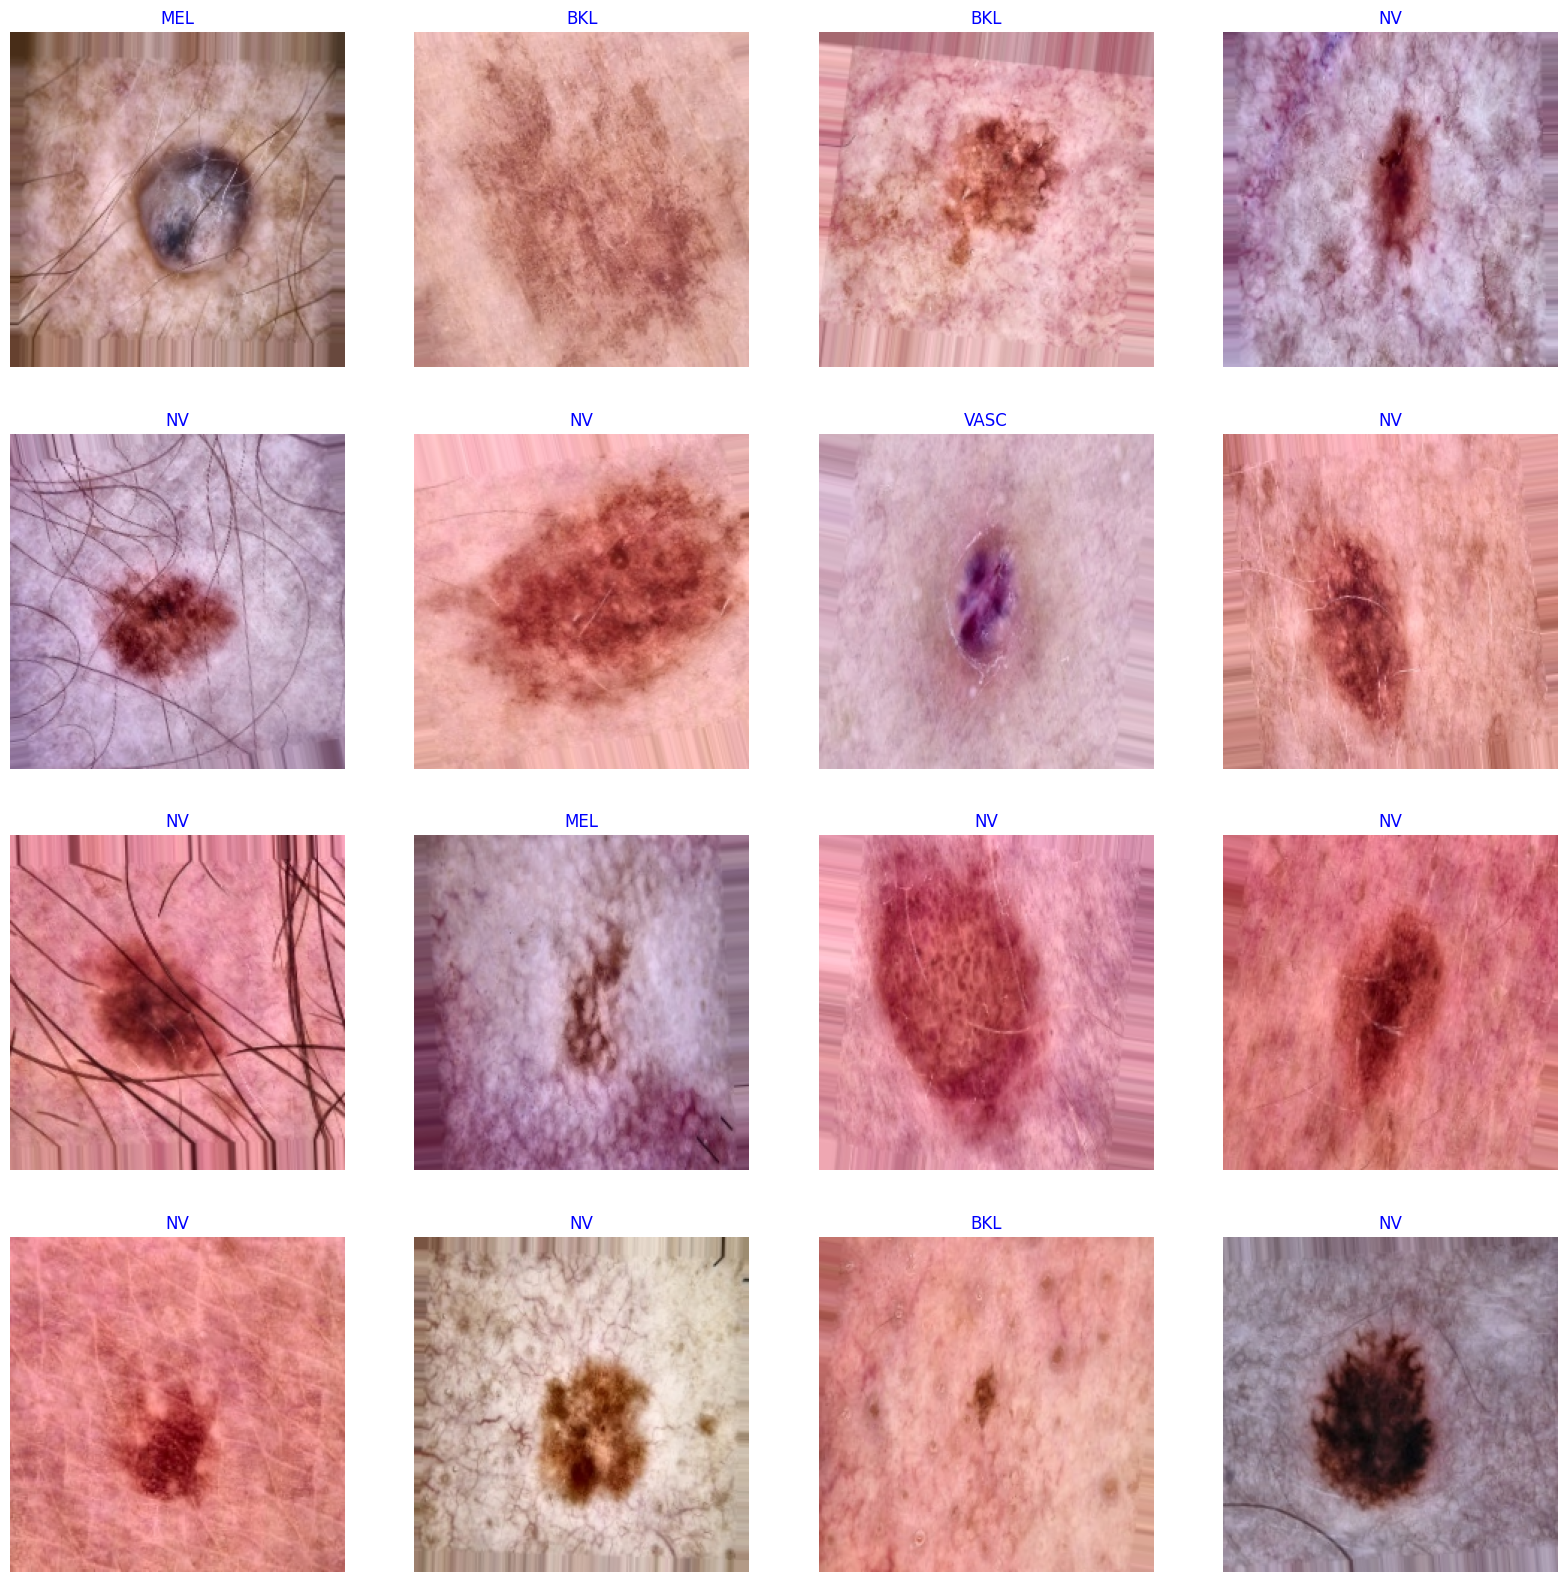

In [13]:
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [14]:
#Not manatory to run
# Number of images in the training set
num_train_images = len(train_df)
print(f"Number of images in the training set: {num_train_images}")

# Number of images in the validation set
num_val_images = len(val_df)
print(f"Number of images in the validation set: {num_val_images}")

# Number of images in the test set
num_test_images = len(test_df)
print(f"Number of images in the test set: {num_test_images}")


Number of images in the training set: 6409
Number of images in the validation set: 1603
Number of images in the test set: 2003


In [15]:
#Weighted Loss Function

import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K

# Calculate class frequencies (the number of images per class)
label_counts = train_df['labels'].value_counts()

# Calculate total number of images
total_images = len(train_df)

# Calculate class weights as the inverse of class frequency
class_weights = {label: total_images / (len(label_counts) * count) for label, count in label_counts.items()}

# Print the calculated class weights
print("Class Weights:", class_weights)

# Prepare the weights for each class to be used in the loss function
class_weight_array = [class_weights[label] for label in sorted(label_counts.index)]

# Convert the list of class weights to a TensorFlow tensor
class_weight_tensor = tf.constant(class_weight_array, dtype=tf.float32)

# Create the weighted loss function
def get_weighted_loss(class_weight_tensor, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        # Calculate the loss for each class
        loss = -K.sum(class_weight_tensor * y_true * K.log(y_pred + epsilon), axis=-1)
        return loss
    return weighted_loss

# Example usage of the weighted loss function with a model
weighted_loss_function = get_weighted_loss(class_weight_tensor)

Class Weights: {'NV': 0.2133701767819689, 'MEL': 1.2859149277688604, 'BKL': 1.3023775655354604, 'BCC': 2.782891880156318, 'AKIEC': 4.380724538619275, 'VASC': 10.061224489795919, 'DF': 12.372586872586872}


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_4 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 256)               327936    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 4384426 (16.73 MB)
Trainable params: 332

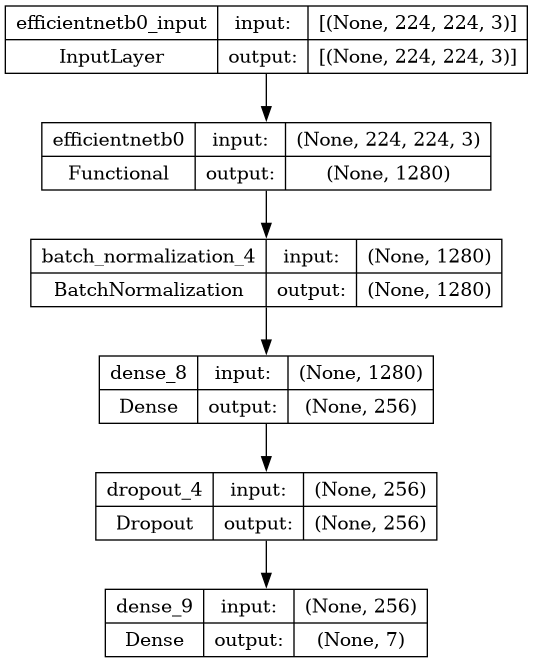

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.utils import plot_model

# Assuming train_gen is your training data generator
class_count = len(list(train_df['labels'].unique()))  # Number of classes

# Create the EfficientNetB0 base model
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')

# Freeze the layers of the base model
base_model.trainable = False

# Build the custom model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# # Build the custom model
# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),  # Use global average pooling to reduce dimensionality
#     layers.BatchNormalization(),
#     layers.Dense(256, kernel_regularizer=regularizers.l2(0.016),
#                 activity_regularizer=regularizers.l1(0.006),
#                 bias_regularizer=regularizers.l1(0.006),
#                 activation='relu'),
#     layers.Dropout(rate=0.3, seed=123),  # Adjust dropout rate if necessary
#     layers.Dense(class_count, activation='softmax')
# ])

# Custom callback for saving the best model weights based on validation accuracy
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_f1_score', mode='max', verbose=1):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        self.best_val_metric = -np.Inf if mode == 'max' else np.Inf
        self.best_train_metric = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_val_metric = logs.get(self.monitor)
        current_train_metric = logs.get('f1_score')  # Reference to training F1Score

        if current_val_metric is None or current_train_metric is None:
            print(f"Warning: {self.monitor} or 'f1_score' not found in logs. Skipping checkpoint.")
            return

        if (self.mode == 'max' and current_val_metric > self.best_val_metric) or \
           (self.mode == 'min' and current_val_metric < self.best_val_metric):
            self.best_val_metric = current_val_metric
            self.best_train_metric = current_train_metric
            self.model.save_weights(self.filepath)
            if self.verbose > 0:
                print(f'\nEpoch {epoch + 1}: {self.monitor} improved to {current_val_metric}, saving model.')

        elif current_val_metric == self.best_val_metric and current_train_metric > self.best_train_metric:
            self.best_train_metric = current_train_metric
            self.model.save_weights(self.filepath)
            if self.verbose > 0:
                print(f'\nEpoch {epoch + 1}: {self.monitor} same as best, but training metric improved to {current_train_metric}, saving model.')

                
def f1_loss(y_true, y_pred):
    # Compute precision and recall
    precision = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32)) / (tf.reduce_sum(y_pred) + K.epsilon())
    recall = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32)) / (tf.reduce_sum(y_true) + K.epsilon())
    
    # Compute F1 score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return 1 - f1  # Return 1 - F1 for minimization


# Define your custom F1Score metric class
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Instantiate the checkpoint callback
checkpoint = CustomModelCheckpoint(
    filepath='best_weights',
    monitor='val_f1_score',  # Monitoring F1 score on the validation set
    mode='max',
    verbose=1
)

# Early stopping to prevent overfitting
early = EarlyStopping(monitor="val_loss", mode="min", patience=8)

# Compile the model with Adamax optimizer and custom F1 score loss function
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss=f1_loss,
              metrics=['accuracy', F1Score(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Print the model summary
model.summary()

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [35]:
#Loss Function Define

def build_lrfn(lr_start=0.000001, lr_max=0.001,
               lr_min=0, lr_rampup_epochs=8,
               lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [36]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

history_data = []

# Define the number of folds for cross-validation
num_folds = 5
epochs = 30  # Adjust as needed

# Initialize k-fold cross-validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize variables to store results
all_accuracies = []

# Perform k-fold cross-validation
fold_count = 0
for train_index, valid_index in skf.split(train_df, train_df['labels']):
    fold_count += 1
    print(f"\nTraining Fold {fold_count}")

    # Split data into training and validation sets
    train_fold, valid_fold = train_df.iloc[train_index], train_df.iloc[valid_index]

    # Data generators for this fold
    train_gen = tr_gen.flow_from_dataframe(
        dataframe=train_fold, x_col='filepaths', y_col='labels', target_size=img_size,
        class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
    )

    valid_gen = ts_gen.flow_from_dataframe(
        dataframe=valid_fold, x_col='filepaths', y_col='labels', target_size=img_size,
        class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
    )

    # Train the model
    history = model.fit(
        x=train_gen, epochs=epochs, verbose=1, validation_data=valid_gen,
        callbacks=[lr_schedule, early, checkpoint], shuffle=False
    )
    history_data.append(history)

    # Evaluate on the validation set of this fold
    valid_accuracy = model.evaluate(valid_gen)[1]
    all_accuracies.append(valid_accuracy)

# Calculate and print the average accuracy across all folds
average_accuracy = np.mean(all_accuracies)
print(f'\nAverage Accuracy across all Folds: {average_accuracy}')


Training Fold 1
Found 5127 validated image filenames belonging to 7 classes.
Found 1282 validated image filenames belonging to 7 classes.

Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/30


2024-08-16 18:05:22.723670: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


80/81 [============================>.] - ETA: 0s - loss: 8.4557 - accuracy: 0.1723 - f1_score: 0.1073 - precision_9: 0.1692 - recall_9: 0.0785
Epoch 1: val_f1_score improved to 0.09479224681854248, saving model.
81/81 [==============================] - 68s 748ms/step - loss: 8.4558 - accuracy: 0.1722 - f1_score: 0.1073 - precision_9: 0.1692 - recall_9: 0.0786 - val_loss: 8.5854 - val_accuracy: 0.2153 - val_f1_score: 0.0948 - val_precision_9: 0.1897 - val_recall_9: 0.0632 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 0.000125875.
Epoch 2/30
80/81 [============================>.] - ETA: 0s - loss: 7.8536 - accuracy: 0.3623 - f1_score: 0.3318 - precision_9: 0.4554 - recall_9: 0.2609
Epoch 2: val_f1_score improved to 0.4718884527683258, saving model.
81/81 [==============================] - 58s 720ms/step - loss: 7.8525 - accuracy: 0.3630 - f1_score: 0.3327 - precision_9: 0.4563 - recall_9: 0.2618 - val_loss: 7.3705 - val_accuracy: 0.4641 - val_f1_score: 0.4719 

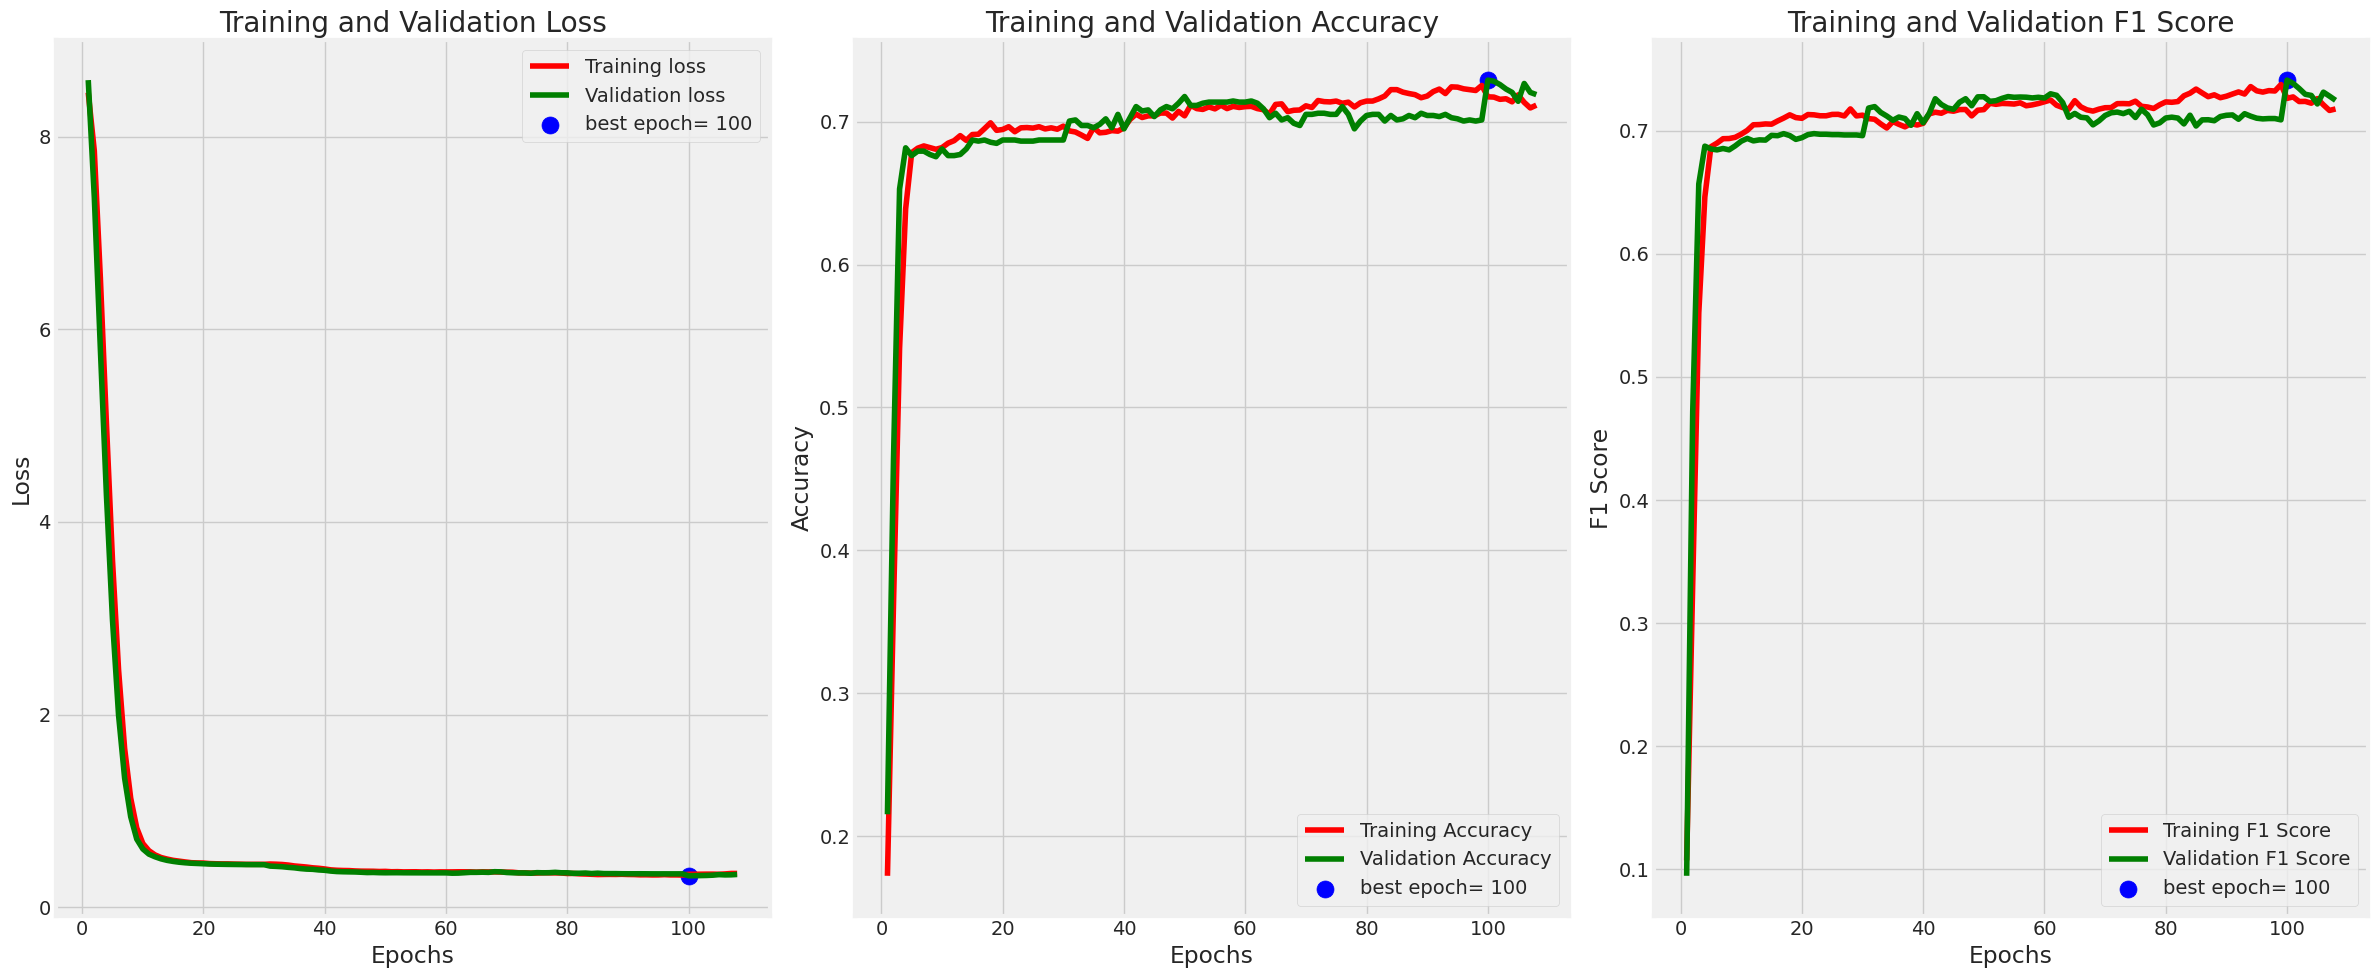

In [37]:
#Curves
tr_acc = []
tr_loss = []
val_acc = []
val_loss = []

tr_f1 = []  # For storing training F1 scores
val_f1 = []  # For storing validation F1 scores

for history in history_data:
    n = len(history.history['accuracy'])
    for i in range(n):
        tr_acc.append(history.history['accuracy'][i])
        tr_loss.append(history.history['loss'][i])
        val_acc.append(history.history['val_accuracy'][i])
        val_loss.append(history.history['val_loss'][i])

        # Add F1 score tracking
        tr_f1.append(history.history['f1_score'][i])
        val_f1.append(history.history['val_f1_score'][i])

# Finding the best epochs for loss, accuracy, and F1 score
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

index_f1 = np.argmax(val_f1)
f1_highest = val_f1[index_f1]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
f1_label = f'best epoch= {str(index_f1 + 1)}'

# Plotting the results
plt.figure(figsize=(24, 10))
plt.style.use('fivethirtyeight')

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.plot(Epochs, tr_f1, 'r', label='Training F1 Score')
plt.plot(Epochs, val_f1, 'g', label='Validation F1 Score')
plt.scatter(index_f1 + 1, f1_highest, s=150, c='blue', label=f1_label)
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [38]:
#Score1
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2003/2003 [==============================] - 5s 2ms/step - loss: 0.3518 - accuracy: 0.7029 - f1_score: 0.7077 - precision_9: 0.7183 - recall_9: 0.6975
Train Loss:  0.3378019630908966
Train Accuracy:  0.7189937829971313
--------------------
Validation Loss:  0.3412591218948364
Validation Accuracy:  0.7189695835113525
--------------------
Test Loss:  0.3518068492412567
Test Accuracy:  0.7029455900192261


In [39]:
#Generating Confusion Matrix
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

Class indices dictionary: {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}
List of class names: ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']


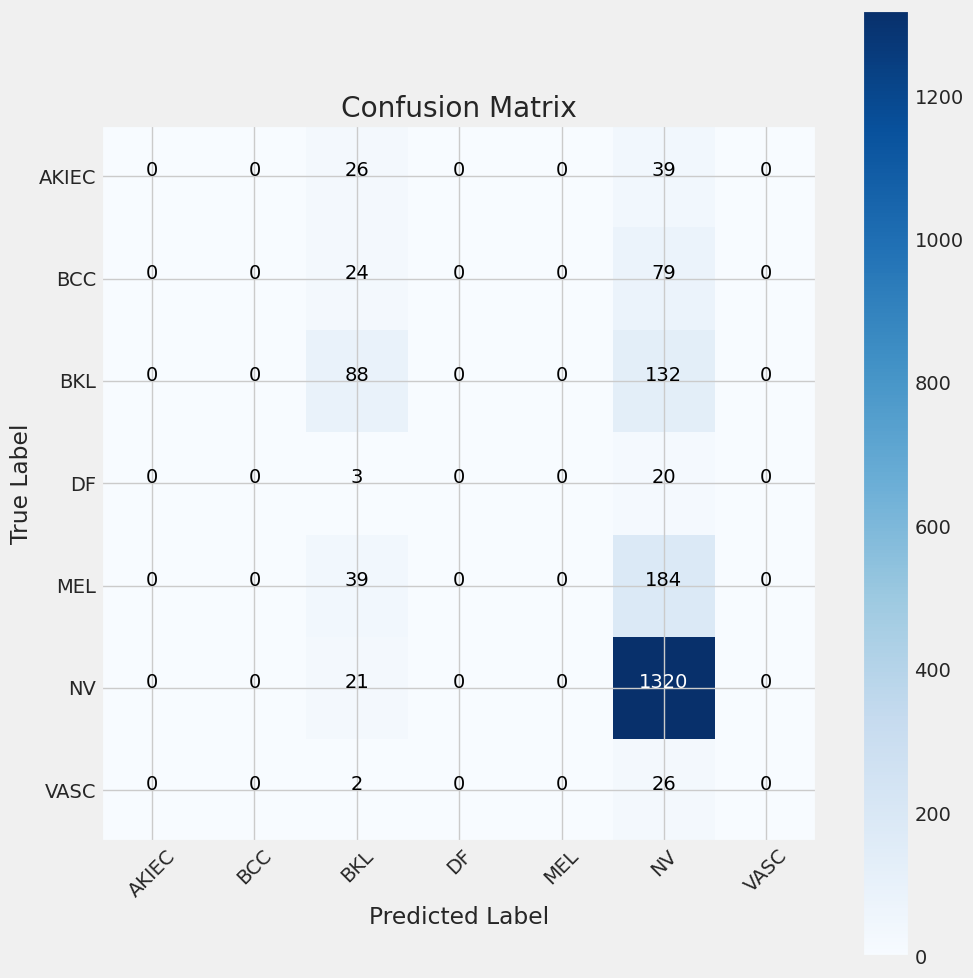

In [40]:
#Confusion Matrix
g_dict = train_gen.class_indices     # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's keys (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator


print("Class indices dictionary:", g_dict)
print("List of class names:", classes)

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [41]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       AKIEC       0.00      0.00      0.00        65
         BCC       0.00      0.00      0.00       103
         BKL       0.43      0.40      0.42       220
          DF       0.00      0.00      0.00        23
         MEL       0.00      0.00      0.00       223
          NV       0.73      0.98      0.84      1341
        VASC       0.00      0.00      0.00        28

    accuracy                           0.70      2003
   macro avg       0.17      0.20      0.18      2003
weighted avg       0.54      0.70      0.61      2003



# Best Weights

In [42]:
#No need to run
# model.save_weights('best_weights')

#First don't run this cell. Run Remaining cell. Then run this cell and rerun remaining cells to check whether anything improves
model.load_weights('best_weights');

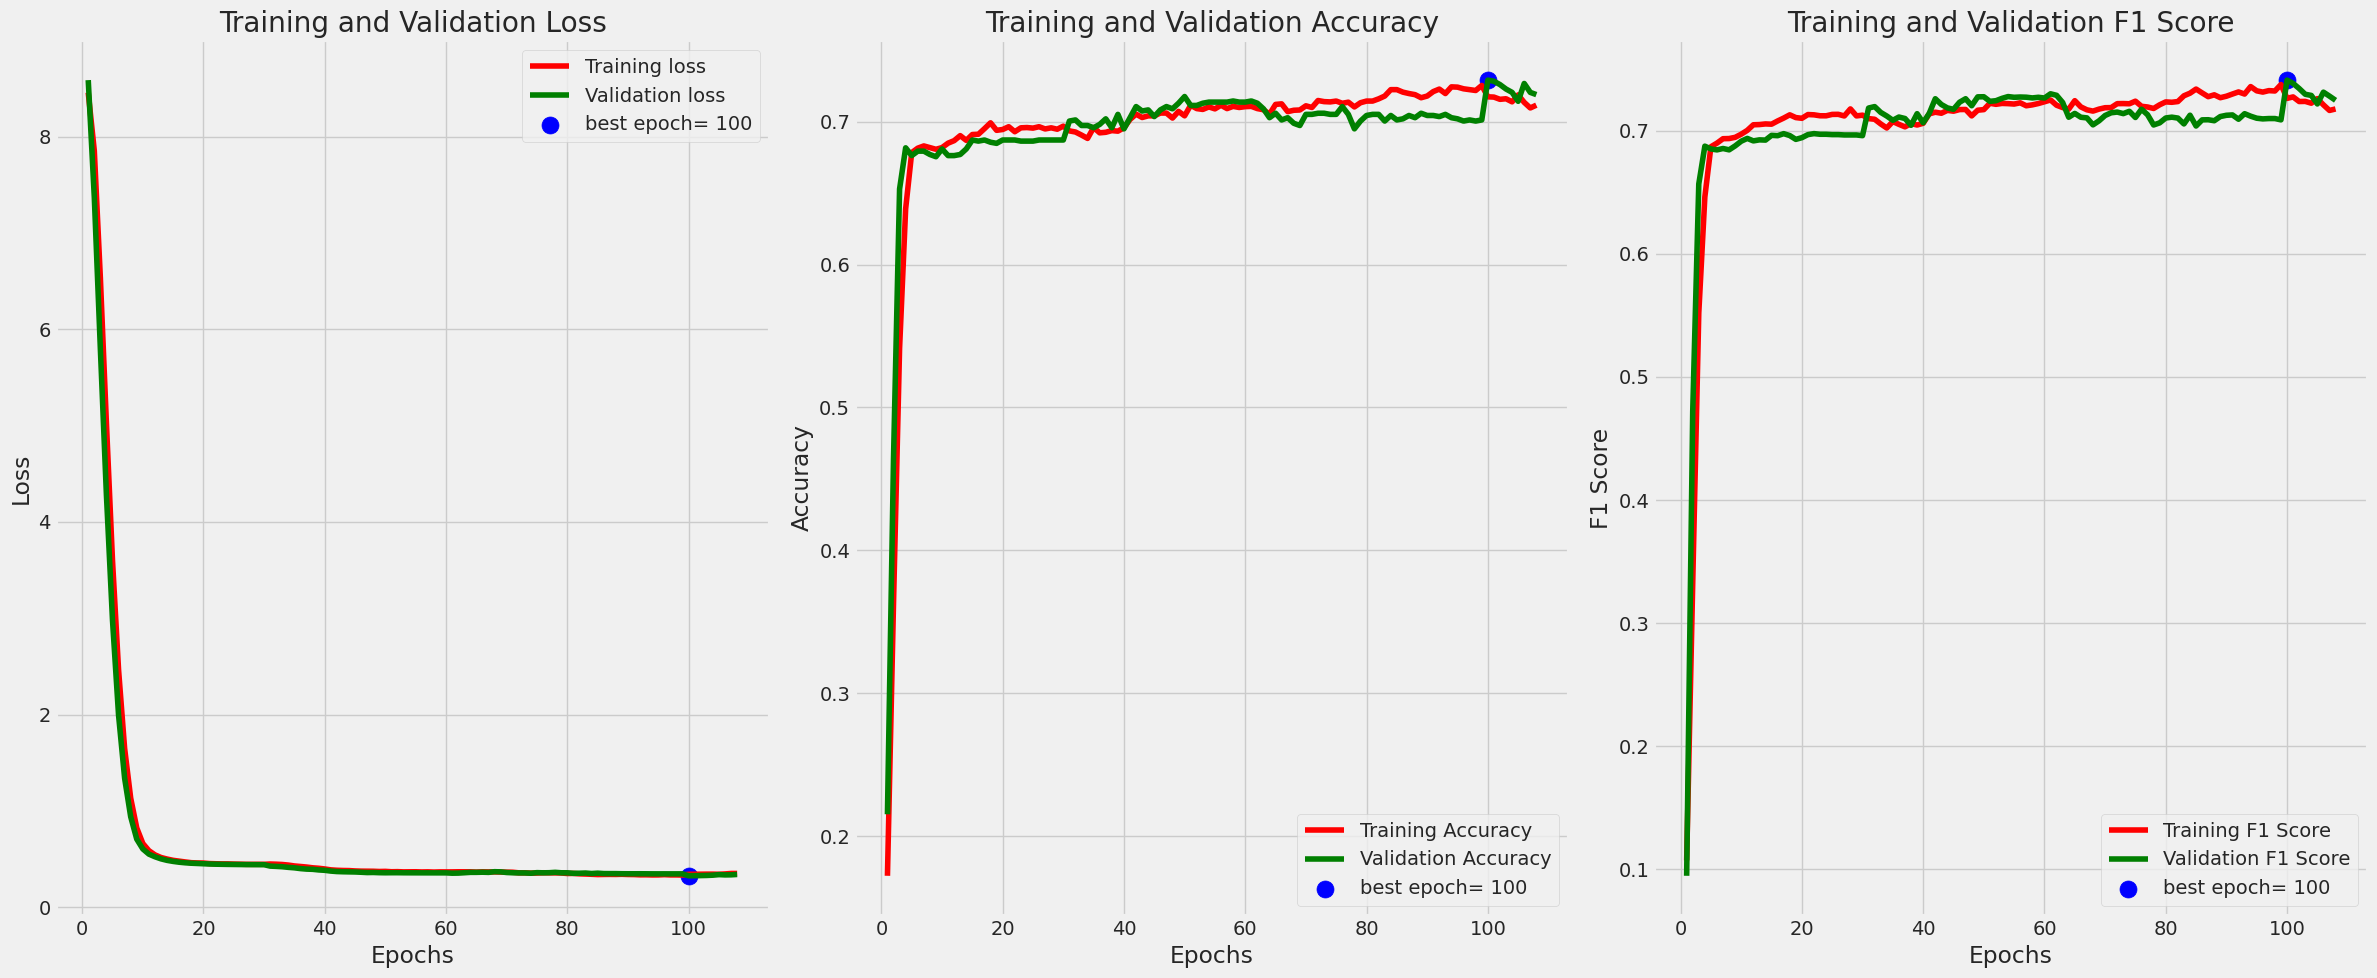

In [43]:
#Curves
tr_acc = []
tr_loss = []
val_acc = []
val_loss = []

tr_f1 = []  # For storing training F1 scores
val_f1 = []  # For storing validation F1 scores

for history in history_data:
    n = len(history.history['accuracy'])
    for i in range(n):
        tr_acc.append(history.history['accuracy'][i])
        tr_loss.append(history.history['loss'][i])
        val_acc.append(history.history['val_accuracy'][i])
        val_loss.append(history.history['val_loss'][i])

        # Add F1 score tracking
        tr_f1.append(history.history['f1_score'][i])
        val_f1.append(history.history['val_f1_score'][i])

# Finding the best epochs for loss, accuracy, and F1 score
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

index_f1 = np.argmax(val_f1)
f1_highest = val_f1[index_f1]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
f1_label = f'best epoch= {str(index_f1 + 1)}'

# Plotting the results
plt.figure(figsize=(24, 10))
plt.style.use('fivethirtyeight')

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.plot(Epochs, tr_f1, 'r', label='Training F1 Score')
plt.plot(Epochs, val_f1, 'g', label='Validation F1 Score')
plt.scatter(index_f1 + 1, f1_highest, s=150, c='blue', label=f1_label)
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
#Score1
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2003/2003 [==============================] - 3s 1ms/step - loss: 0.3456 - accuracy: 0.7099 - f1_score: 0.7163 - precision_9: 0.7324 - recall_9: 0.7009
Train Loss:  0.3314838707447052
Train Accuracy:  0.7228938937187195
--------------------
Validation Loss:  0.3272591233253479
Validation Accuracy:  0.7291178703308105
--------------------
Test Loss:  0.34559333324432373
Test Accuracy:  0.7099350690841675


In [45]:
#Generating Confusion Matrix
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

Class indices dictionary: {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}
List of class names: ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']


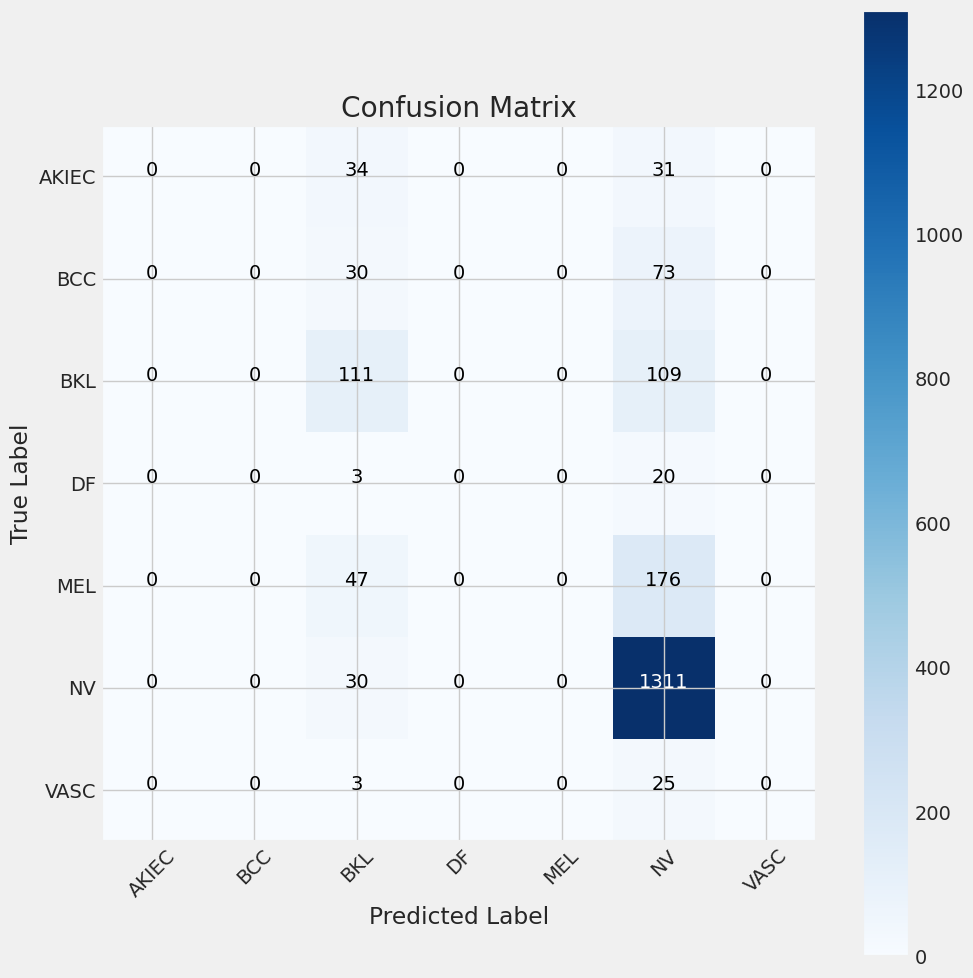

In [46]:
#Confusion Matrix
g_dict = train_gen.class_indices     # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's keys (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator


print("Class indices dictionary:", g_dict)
print("List of class names:", classes)

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [47]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       AKIEC       0.00      0.00      0.00        65
         BCC       0.00      0.00      0.00       103
         BKL       0.43      0.50      0.46       220
          DF       0.00      0.00      0.00        23
         MEL       0.00      0.00      0.00       223
          NV       0.75      0.98      0.85      1341
        VASC       0.00      0.00      0.00        28

    accuracy                           0.71      2003
   macro avg       0.17      0.21      0.19      2003
weighted avg       0.55      0.71      0.62      2003



## Thresholding

In [48]:
preds = model.predict_generator(test_gen)  # Ensure this gives probabilities
y_pred_prob = preds  # This should be the raw probabilities, not class indices
y_val_labels = np.array(test_gen.classes)  # Convert to numpy array

In [49]:
from sklearn.metrics import f1_score

thresholds = np.linspace(0, 1, 101)
best_thresholds = {}
f1_scores = {}

# Iterate over each class to find the best threshold
for class_idx in range(y_pred_prob.shape[1]):  # Each column in y_pred_prob corresponds to a class
    y_true_binary = (y_val_labels == class_idx).astype(int)
    best_f1 = 0
    best_threshold = 0

    for threshold in thresholds:
        y_pred_class = (y_pred_prob[:, class_idx] >= threshold).astype(int)
        f1 = f1_score(y_true_binary, y_pred_class)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    best_thresholds[class_idx] = best_threshold
    f1_scores[class_idx] = best_f1
    print(f"Class {class_idx}: Best Threshold = {best_threshold}, F1-Score = {best_f1}")

Class 0: Best Threshold = 0.03, F1-Score = 0.21800947867298576
Class 1: Best Threshold = 0.02, F1-Score = 0.3286908077994429
Class 2: Best Threshold = 0.23, F1-Score = 0.4946236559139785
Class 3: Best Threshold = 0.02, F1-Score = 0.08849557522123894
Class 4: Best Threshold = 0.01, F1-Score = 0.2978723404255319
Class 5: Best Threshold = 0.9, F1-Score = 0.8887293610911701
Class 6: Best Threshold = 0.01, F1-Score = 0.04958677685950413


Class 0: Best Threshold = 0.03, F1-Score = 0.21800947867298576
Class 1: Best Threshold = 0.02, F1-Score = 0.3286908077994429
Class 2: Best Threshold = 0.23, F1-Score = 0.4946236559139785
Class 3: Best Threshold = 0.02, F1-Score = 0.08849557522123894
Class 4: Best Threshold = 0.01, F1-Score = 0.2978723404255319
Class 5: Best Threshold = 0.9, F1-Score = 0.8887293610911701
Class 6: Best Threshold = 0.01, F1-Score = 0.04958677685950413


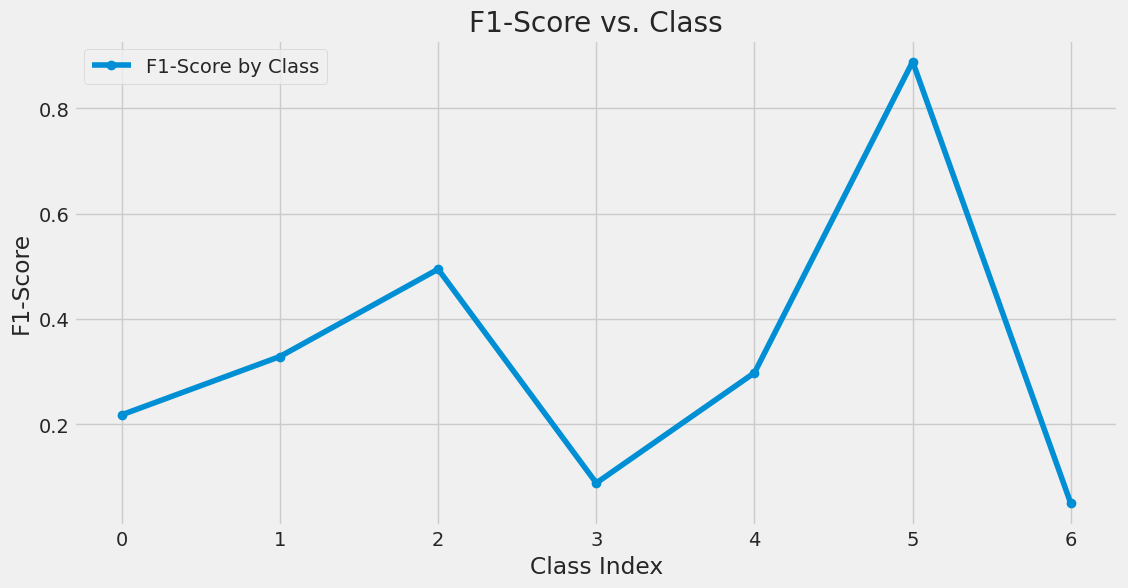

In [50]:
thresholds = np.linspace(0, 1, 101)
best_thresholds = {}
f1_scores = {}

# Find the best threshold for each class
for class_idx in range(y_pred_prob.shape[1]):
    y_true_binary = (y_val_labels == class_idx).astype(int)
    best_f1 = 0
    best_threshold = 0

    for threshold in thresholds:
        y_pred_class = (y_pred_prob[:, class_idx] >= threshold).astype(int)
        f1 = f1_score(y_true_binary, y_pred_class)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    best_thresholds[class_idx] = best_threshold
    f1_scores[class_idx] = best_f1
    print(f"Class {class_idx}: Best Threshold = {best_threshold}, F1-Score = {best_f1}")

# Optional: Plot the F1-scores
plt.figure(figsize=(12, 6))
plt.plot(f1_scores.keys(), f1_scores.values(), 'o-', label='F1-Score by Class')
plt.xlabel('Class Index')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Class')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
import numpy as np

# Assuming you have your best thresholds in best_thresholds
# and your model's predictions in preds

# Get the probabilities from your model
preds = model.predict_generator(test_gen)
y_pred_prob = preds  # This should be the probabilities

# Initialize an empty array for the final predictions
y_pred_final = np.zeros((y_pred_prob.shape[0], y_pred_prob.shape[1]))

# Apply thresholds to get binary predictions
for class_idx, threshold in best_thresholds.items():
    y_pred_final[:, class_idx] = (y_pred_prob[:, class_idx] >= threshold).astype(int)

# Convert the binary predictions to class labels
# For multi-label classification, you might want to keep it in binary format
# For single-label classification, you can use np.argmax to get the final class
if y_pred_final.shape[1] == 1:  # Single-label classification
    y_pred_final_labels = (y_pred_final[:, 0] > 0.5).astype(int)
else:  # Multi-label classification
    y_pred_final_labels = np.argmax(y_pred_final, axis=1)

# Print or evaluate the final predictions
print(y_pred_final_labels)

[4 5 5 ... 2 0 5]


In [52]:
# Classification report
print(classification_report(test_gen.classes, y_pred_final_labels, target_names= classes))

              precision    recall  f1-score   support

       AKIEC       0.16      0.35      0.22        65
         BCC       0.16      0.17      0.17       103
         BKL       0.46      0.44      0.45       220
          DF       0.00      0.00      0.00        23
         MEL       0.23      0.17      0.20       223
          NV       0.88      0.90      0.89      1341
        VASC       0.00      0.00      0.00        28

    accuracy                           0.69      2003
   macro avg       0.27      0.29      0.27      2003
weighted avg       0.68      0.69      0.68      2003

